(code_details)=
# Code Details

This section serves as a demonstration on how to use ExpansionSuite code to solve recursive models.

We start by assigning values to model parameters and defining equilibrium conditions. We decide to include the following variables as $X_t$ and $X_{t+1}$ in expansion.

For the **internal habit** specification, the first **6** variables in the table below are considered as **jump variables**, and the last **6** are considered as **state variables**. 

For the **external habit** specification, we don't have $\frac{MH_t}{MU_t}$ in the model, and all the other variables are still there, so there will be **5 controls and 6 states**. <font color='red'>LPH indicated that he didn't like the naming of "control" and "state". There will be a new terminology in the future.</font><font color='red'>LPH indicated that he didn't like the naming of "control" and "state". There will be a new terminology in the future.</font>

To avoid any confusion, the table below also provides the name of variables in the code to connect them with their math expressions.

| Python Index | Code name | Corresponding $X_t$ variable| Code name | Corresponding $X_{t+1}$ Variable| Category |
|:-:|:---------:|:---------:|:---------:|:---------:|:---------:|
|0|`vmy_t`|$\log\left(\frac{V_t}{Y_t}\right)$|`vmy_tp1`|$\log\left(\frac{V_{t+1}}{Y_{t+1}}\right)$ | jump
|1|`rmy_t`|$\log\left(\frac{R_t}{Y_t}\right)$|`rmy_tp1`|$\log\left(\frac{R_{t+1}}{Y_{t+1}}\right)$ | jump
|2|`umy_t`|$\log\left(\frac{U_t}{Y_t}\right)$|`umy_tp1`|$\log\left(\frac{U_{t+1}}{Y_{t+1}}\right)$ | jump
|3|`cmy_t`|$\log\left(\frac{C_t}{Y_t}\right)$|`cmy_tp1`|$\log\left(\frac{C_{t+1}}{Y_{t+1}}\right)$ | jump
|4|`mhmu_t`|$\log\left(\frac{MH_t}{MU_t}\right)$|`mhmu_tp1`|$\log\left(\frac{MH_{t+1}}{MU_{t+1}}\right)$| jump
|5|`mcmu_t`|$\log\left(\frac{MC_t}{MU_t}\right)$|`mcmu_tp1`|$\log\left(\frac{MC_{t+1}}{MU_{t+1}}\right)$| jump
|6|`IoverY_t`|$\frac{K_{t+1}-K_{t}}{Y_{t}}$|`IoverY_tp1`|$\frac{K_{t+2}-K_{t+1}}{Y_{t+1}}$| jump
|7|`hmy_t`|$\log\left(\frac{H_t}{Y_t}\right)$|`hmy_tp1`|$\log\left(\frac{H_{t+1}}{Y_{t+1}}\right)$| state
|8|`KoverY_t`|$\frac{K_t}{Y_t}$|`KoverY_tp1`|$\frac{K_{t+1}}{Y_{t+1}}$| state
|9|`gy_t`|$\log\left(\frac{Y_t}{Y_{t-1}}\right)$|`gy_tp1`| $\log\left(\frac{Y_{t+1}}{Y_t}\right)$| state
|10|`z1_t`|$Z_{1,t}$|`z1_tp1`|$Z_{1,t+1}$| state
|11|`z2_t`|$Z_{2,t}$|`z2_tp1`|$Z_{2,t+1}$| state
|12|`z2l_t`|$Z_{2,t-1}$|`z2l_tp1`|$Z_{2,t}$| state

Note that $KoverY_t \equiv \frac{K_t}{Y_t}$ is approximated as its level rather than logarithm in this model, because we intend to allow for negative capital (borrowing) in the evolution of $\frac{K_t}{Y_t}$, as actually happens in so-called open economy models.

## User Input 1: Equilibrium Conditions

In [1]:
import numpy as np
import autograd.numpy as anp

# Model parameters
γ = 10.
ρ = 2./3

χ = 0.9
α = 0.9
ϵ = 10.

a = .00663 # risk free growth rate of capital
g = .00373 # deterministic growth trend of income
A = np.array([[.704, 0, 0],[0, 1, -.154],[0,1,0]])
B = np.array([[0.144,0],[0,0.206],[0,0]])

internal = True #True: internal habit; False: external habit.

KoverY_ss = 0.

args = (γ, ρ, χ, α, ϵ, a, g, A, B, internal, KoverY_ss)

'''
f=[f1,f2] which satisfy E[Mf1] = 0 and f2=0.

'''
def eq_cond(X_t, X_tp1, W_tp1, q, *args):
    # Parameters for the model
    γ, ρ, χ, α, ϵ, a, g, A, B, internal, _ = args

    # Variables:
    # log V_t/Y_t, log R_t/Y_t, log U_t/Y_t, log C_t/Y_t,log MH_t/MU_t, log MC_t/MU_t, I_t/Y_t - JUMP VARIABLES
    # log H_t/Y_t, K_t/Y_t, log(Y_t/Y_{t-1}), Z_{1,t}, Z_{2,t}, Z_{2,t-1} - STATE VARIABLES
    if internal:
        vmy_t, rmy_t, umy_t, cmy_t, mhmu_t,mcmu_t, IoverY_t, \
            hmy_t, KoverY_t, gy_t, z1_t, z2_t, z2l_t= X_t.ravel()
        vmy_tp1, rmy_tp1, umy_tp1, cmy_tp1, mhmu_tp1, mcmu_tp1, IoverY_tp1, \
            hmy_tp1, KoverY_tp1, gy_tp1, z1_tp1, z2_tp1, z2l_tp1= X_tp1.ravel()
    else:
        vmy_t, rmy_t, umy_t, cmy_t, mcmu_t, IoverY_t, \
            hmy_t, KoverY_t, gy_t, z1_t, z2_t, z2l_t= X_t.ravel()
        vmy_tp1, rmy_tp1, umy_tp1, cmy_tp1, mcmu_tp1, IoverY_tp1, \
            hmy_tp1, KoverY_tp1, gy_tp1, z1_tp1, z2_tp1, z2l_tp1= X_tp1.ravel()

    # Exogenous states (stacked together)
    Z_t = anp.array([z1_t, z2_t, z2l_t])
    Z_tp1 = anp.array([z1_tp1, z2_tp1, z2l_tp1])

    # log SDF in units of U, EXCLUDING the change of measure term
    β = anp.exp(g * ρ - anp.log(1 + a))
    sdf_u = anp.log(β) + (ρ - 1) * (vmy_tp1 + gy_tp1 - rmy_t) - ρ * (umy_tp1 + gy_tp1 - umy_t)
    sdf_ex = sdf_u + mcmu_tp1 - mcmu_t

    # Eq0: Change of measure evaluated at γ=0. --- (2) in Section 1
    # THIS CHANGE OF MEASURE EQUATION MUST BE THE FIRST EQUATION. Order of others doesn't matter.
    m = vmy_tp1 + gy_tp1 - rmy_t
    # Eq1: Recursive utility --- (1) in Section 1
    if ρ == 1.:
        res_1 = anp.exp((1-β)*umy_t) * anp.exp(β*rmy_t) - anp.exp(vmy_t)
    else:
        res_1 = (1-β)*anp.exp((1-ρ)*(umy_t)) + β*anp.exp((1-ρ)*(rmy_t)) - anp.exp((1-ρ)*(vmy_t))
    # Eq2: Utility function --- (3) in Section 1
    if ϵ == 1.:
        res_2 = anp.exp((1-α)*cmy_t) * anp.exp(α*hmy_t) - anp.exp(umy_t)
    else:
        res_2 = anp.log((1-α)*anp.exp((1-ϵ)*cmy_t)+α*anp.exp((1-ϵ)*hmy_t))/(1-ϵ) - (umy_t)
    # Eq3: FOC on investment --- (9) in Section 1
    res_3 = anp.log(1+a) + sdf_ex
    if internal:
        # Eq4: MC/MU --- (8-a) in Section 1
        res_4 = (1-α)*anp.exp(ϵ*(umy_t-cmy_t)) + (1-χ)*anp.exp(sdf_u+mhmu_tp1) - anp.exp(mcmu_t)
        # Eq5: MH/MU --- (8-b) in Section 1
        res_5 = α*anp.exp(ϵ*(umy_t-hmy_t)) + χ*anp.exp(sdf_u+mhmu_tp1) - anp.exp(mhmu_t)
    else:
        # Eq4: MC/MU --- (8) in Section 1. No MH/MU when external.
        res_4 = (1-α)*anp.exp(ϵ*(umy_t-cmy_t)) - anp.exp(mcmu_t)
    # Eq6: Capital growth --- (5-b) in Section 1
    res_6 = KoverY_tp1 * anp.exp(gy_tp1) + anp.exp(cmy_t) - ((1+a)*KoverY_t + 1)
    # Eq7: Habit evolution --- (4) in Section 1
    res_7 = anp.exp(hmy_tp1+gy_tp1) - χ*anp.exp(hmy_t) - (1-χ)*anp.exp(cmy_t)
    # Eq8: Nonfinancial income process --- (6) in Section 1
    res_8 = gy_tp1 - .01 * (z1_tp1 + z2_tp1 - z2_t) - g
    # Eq9-11: State process  --- (7) in Section 1
    res_9 = (A@Z_t + B@W_tp1 - Z_tp1)[0]
    res_10 = (A@Z_t + B@W_tp1 - Z_tp1)[1]
    res_11 = (A@Z_t + B@W_tp1 - Z_tp1)[2]
    
    res_12 = KoverY_tp1 * anp.exp(gy_tp1) - KoverY_t - IoverY_t
    
    if internal:
        return anp.array([m, res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_12, res_8,res_9, res_10, res_11])
    else:
        return anp.array([m, res_1,res_2,res_3,res_4,res_6,res_7,res_12, res_8,res_9, res_10, res_11])

## User Input 2: Steady States
After having parameters and equilibrium conditions defined, we also need to define a function that returns the deterministic steady state (0th order expansion) value of model variables.

For this model, we have a free initial condition that can be imposed on $\frac{K_0^0}{Y_0^0}$, i.e. there is a family of steady states indexed by $\frac{K_0^0}{Y_0^0}$ subject to the restriction $\frac{C_0^0}{Y_0^0} > 0$ (otherwise we cannot take the logarithm of it).

In the following example, we impose $\frac{K_0^0}{Y_0^0} = 0$ as its deterministic steady state value. Once this is imposed, we can solve for the steady state value of others with some effort in algebra.

In [2]:
def ss_func(*args):

    '''
    User-defined function to calculate steady states.

    Alternatively, users can simply provide a hard-coded np.array for steady states.

    '''
    
    # Extra parameters for the model
    γ, ρ, χ, α, ϵ, a, g, A, B, internal, KoverY_ss = args
    
    KoverY = KoverY_ss # This is a condition that we can freely impose
    β = np.exp(g * ρ - np.log(1+a)) # From FOC (9)
    gy = g # From (6). This is just the deterministic growth trend of income

    # Starting from the steady state of Y_{t+1}/Y_{t} and K/Y,
    # we can solve the steady state of other variables by hand:
    cmy = np.log(((1+a) - np.exp(g)) * KoverY + 1) # From (5-b)
    hmy = np.log(1-χ) + cmy - np.log((np.exp(g) - χ)) # From (4)
    if ϵ == 1.:
        umy = (1-α)*cmy + α*hmy # From (3) special case
    else:
        umy = np.log((1-α)*np.exp((1-ϵ)*cmy) + α * np.exp((1-ϵ)*hmy)) / (1-ϵ) # From (3)

    λ = β * np.exp((1-ρ)*g)
    
    if ρ == 1.:
        vmy = (1-β)*umy + β*rmy # From (1) special case
    else:
        vmy = (np.log((1-β)*np.exp((1-ρ)*umy)) - np.log(1-λ)) / (1-ρ) # From (1)
    rmy = vmy + gy # From (2)
    
    IoverY = KoverY*(np.exp(gy)-1)
    
    # steady state of Z components (=0, by stationarity of the two AR process)
    z1 = 0.
    z2 = 0.
    z2l = 0.
    
    if internal:
        mhmu = np.log(α) + ϵ * (umy - hmy) - np.log(1 - χ * β * np.exp(-g * ρ)) # From (8'-b)
        mcmu = np.log((1-α) * np.exp(ϵ * (umy - cmy)) + (1 - χ) * β * np.exp(-g * ρ) * np.exp(mhmu)) # From (8'-a)
        X_0 = np.array([vmy, rmy, umy, cmy, mhmu, mcmu, IoverY, hmy, KoverY, gy, z1, z2, z2l])
        
    else:
        mcmu = np.log((1-α) * np.exp(ϵ * (umy - cmy))) # From (8)
        X_0 = np.array([vmy, rmy, umy, cmy, mcmu, IoverY, hmy, KoverY, gy, z1, z2, z2l])
        
    return X_0

## Solving (Approximate) Equilibrium Law of Motion
Once we have the above two pieces of user inputs at hand, we are ready to apply small-noise expansion method to solve for (approximate) the equilibrium law of motion of every variable in the model. Let's first try a 1st order approximation.

In [3]:
from expansion import recursive_expansion

if internal:
    var_shape = (7,6,2) # (number of controls, number of states, number of shocks)
else:
    var_shape = (6,6,2)

modelSol = recursive_expansion(eq_cond=eq_cond,
                               ss=ss_func,
                               var_shape=var_shape, 
                               γ=args[0],
                               second_order=False,# False: only 1st order expansion; True: include 2nd order expansion
                               args=args)

/opt/anaconda3/lib/python3.8/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


The approximate law of motion given by small-noise expansion method takes the form of a familiar **linear state-space system**: It represents $X_{t+1}$, **all variables** (including both control variables and state variables) at time $t+1$, only using **state variables** at time $t$ and **shock** at time $t+1$. 

If we partition $X_{t} = \begin{bmatrix} Y_t\\ Z_t\end{bmatrix}$ where $Y_t$ and $Z_t$ stand for time $t$ control and state variables respectively, the first order approximation of $X_{t+1} $ will take the form

\begin{align*}
    Y_{t+1}^1 &= D Z_{t}^1 + F W_{t+1} + H\\
    Z_{t+1}^1 &= A Z_{t}^1 + B W_{t+1} + C
\end{align*}
or
\begin{equation*}
    X_{t+1}^1 = \begin{bmatrix} D\\A \end{bmatrix} Z_t^1 + \begin{bmatrix} F\\B \end{bmatrix} W_{t+1} + \begin{bmatrix} H\\C \end{bmatrix}
\end{equation*}

<!-- 
The second order approximation of $X_{t+1}$ will have a bit complicated structure:

\begin{align*}
    Y_{t+1}^2 &= D Z_{t}^1 + F W_{t+1} + H\\
    Z_{t+1}^2 &= A Z_{t}^1 + B W_{t+1} + C
\end{align*} -->

Let's print the first order coefficients out in the approximation that we just ran. You can easily tell what are the corresponding matrices $D$, $F$, $A$, $B$, $H$ and $C$. These coefficients are represented in a dictionary, so if you need the value of a specific coefficient matrix, you can conveniently extract it from the dictionary using the corresponding key 'c', 'w' or 'x'.

<font color='red'>Second order approximation takes a bit more complicated structure. I haven't written it down.</font>

In [4]:
np.set_printoptions(precision=6,suppress=True)
modelSol.X1_tp1.coeffs # First order LOM coefficients

{'c': array([[-0.034644],
        [-0.034744],
        [-0.      ],
        [ 0.      ],
        [ 0.000184],
        [ 0.000191],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]]),
 'w': array([[ 0.00327 , -0.002023],
        [ 0.003283, -0.002023],
        [-0.001108, -0.002057],
        [ 0.003045, -0.002025],
        [ 0.000491,  0.000004],
        [-0.003007, -0.000024],
        [-0.003045,  0.002025],
        [-0.00144 , -0.00206 ],
        [ 0.      ,  0.      ],
        [ 0.00144 ,  0.00206 ],
        [ 0.144   ,  0.      ],
        [ 0.      ,  0.206   ],
        [ 0.      ,  0.      ]]),
 'x': array([[ 0.022513,  0.002828,  0.      ,  0.015984, -0.009595,  0.001512],
        [ 0.020151,  0.002835,  0.      ,  0.01604 , -0.009618,  0.001512],
        [ 0.841974,  0.000457,  0.      , -0.003318, -0.001551,  0.001536],
        [ 0.064614,  0.002706,  0.      ,  0.014992, -0.009182, 

With the law of motion at hand, it would be a piece of cake to perform tasks such as simulation, or compute important quantities that reflect the dynamics in the model, for example, impulse response functions. The ExpansionSuite code provides such functionalities.

## Simulation
Suppose we are interested in knowing how the model variable $\log(\frac{C_t}{Y_t})$ evolves over time if it follows the (approximate) equilibrium law of motion. We just need to generate shocks throughout the horizon that we are interested in (for example, 100 periods), and feed the shocks to the `simulate` method of `modelSol`.

In the cell below, we first try 0 shocks (i.e. examine the deterministic path) and then try bivariate standard normal shocks.

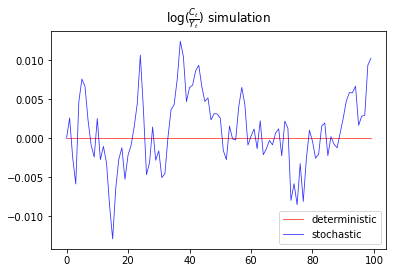

In [5]:
T = 100 # time horizon for simulation
_, _, n_W = modelSol.var_shape # the number of shocks within this model
Ws_1 = np.zeros((T,n_W)) # "generate" zero shocks throughout the horizon T=100
sim_result_1 = modelSol.simulate(Ws_1) # feed the generated shocks to the simulate method

Ws_2 = np.random.multivariate_normal(np.zeros(n_W), np.eye(n_W), size = T) # generate N(0,I) shocks
sim_result_2 = modelSol.simulate(Ws_2) # feed the generated shocks to the simulate method

import matplotlib.pyplot as plt
# sim_result contains the simulated value of all 12 model variables over the specified horizon
# recall that we arranged log(C_t/Y_t) as the 4th control variable, and python index starts from 0
plt.plot(sim_result_1[:,3], 'r', lw = .8, alpha = .8, label = 'deterministic') 
plt.plot(sim_result_2[:,3], 'b', lw = .8, alpha = .8, label = 'stochastic')
plt.legend()
plt.title(r'$\log(\frac{C_t}{Y_t})$ simulation')
plt.show()

It turns out that in equilibrium, the deterministic path of $\log(\frac{C_t}{Y_t})$ is $\log(\frac{C_t}{Y_t}) \equiv 0$ for any $t$, and the stochastic path oscillate around the deterministic path. This implies that consumption and income have the same deterministic growth rate in equilibrium, which doesn't come as a surprise (as expected from the FOC on investment).

## Computing Impulse Response Functions
You may remember this is not the first time that you see impusle response functions in this notebook: Previously, we computed and plotted the IRFs of income process to two shocks, without knowing small-noise expansion at all! At that time, we only made use of the law of motion that $Y_t$ and the two components follow to construct IRFs.

Now that we're using small-noise expasion method, we have included a bunch of more variables in the linear space-system, we are able to use the approximate law of motion to construct **"new" IRFs** of income, again to the two shocks. How will the "new" IRFs look like? We can directly use the `IRF` method of `modelSol` to obtain the results.

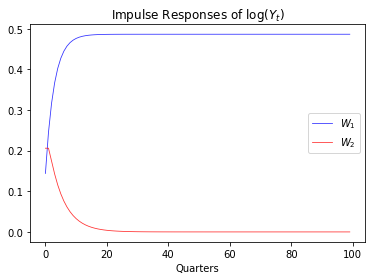

In [6]:
states_IRF = []
controls_IRF = []
T = 100 # time horizon for IRF computation
for shock_index in [0,1]: # we have two shocks for this model
    states, controls = modelSol.IRF(T, shock_index)
    states_IRF.append(states)
    controls_IRF.append(controls)

plt.plot(np.cumsum(states_IRF[0][:,2])*100, color='b', lw=0.8, alpha=0.8, label = "$W_1$")
plt.plot(np.cumsum(states_IRF[1][:,2])*100, color='r', lw=0.8, alpha=0.8, label = "$W_2$")
plt.legend()
plt.xlabel("Quarters")
plt.title("Impulse Responses of $\log(Y_t)$")
# plt.savefig("IncomeIRF", dpi = 300)
plt.show()

It turns out that we actually get the same IRFs as we did previously. This is because the approximate law of motion of $\log(\frac{Y_{t+1}}{Y_t})$ obtained using small-noise expansion is equivalent to its "true" law of motion that we have described in Section 1.2. 

We can verify this by simply inspecting the coefficients of $\log(\frac{Y_{t+1}}{Y_t})$ on **each time $t$ state variable** printed below. Remember, we have 6 control variables and 6 state variables in the model, and $\log(\frac{Y_{t+1}}{Y_t})$ is the 3rd state variable. Therefore, the relevant coefficients of $\log(\frac{Y_{t+1}}{Y_t})$ is on the 9th row.

The coefficients of $\log(\frac{Y_{t+1}}{Y_t})$ on $Z_{1,t}$, $Z_{2,t}$ and $Z_{2,t-1}$, $W_{1, t+1}$ and $W_{2, t+1}$ are .00704, 0, -.00154, .00144, .00206, respectively. These numbers are the same as in the "true" law of motion. The coefficients on other state variables are 0.

In [7]:
modelSol.X1_tp1['x']

array([[ 0.022513,  0.002828,  0.      ,  0.015984, -0.009595,  0.001512],
       [ 0.020151,  0.002835,  0.      ,  0.01604 , -0.009618,  0.001512],
       [ 0.841974,  0.000457,  0.      , -0.003318, -0.001551,  0.001536],
       [ 0.064614,  0.002706,  0.      ,  0.014992, -0.009182,  0.001514],
       [-0.09187 ,  0.000266,  0.      ,  0.002164, -0.000902, -0.000003],
       [ 0.562755, -0.001628,  0.      , -0.013255,  0.005524,  0.000016],
       [-0.065087,  0.003925,  0.      , -0.015137,  0.009242, -0.001513],
       [ 0.904058,  0.000278,  0.      , -0.00478 , -0.000942,  0.001537],
       [-0.071416,  1.000207,  0.      , -0.021785,  0.009078,  0.000026],
       [ 0.      ,  0.      ,  0.      ,  0.00704 ,  0.      , -0.00154 ],
       [ 0.      ,  0.      ,  0.      ,  0.704   ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.      , -0.154   ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.      ,  0.      ]])

In [8]:
modelSol.X1_tp1['w']

array([[ 0.00327 , -0.002023],
       [ 0.003283, -0.002023],
       [-0.001108, -0.002057],
       [ 0.003045, -0.002025],
       [ 0.000491,  0.000004],
       [-0.003007, -0.000024],
       [-0.003045,  0.002025],
       [-0.00144 , -0.00206 ],
       [ 0.      ,  0.      ],
       [ 0.00144 ,  0.00206 ],
       [ 0.144   ,  0.      ],
       [ 0.      ,  0.206   ],
       [ 0.      ,  0.      ]])